In [1]:
%matplotlib inline
import random
random.seed(1234)
from string import punctuation
import pandas as pd
import gzip
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# import nltk
# nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
import spacy
import matplotlib.pyplot as plt
import pyLDAvis #python library for interactive topic model visualization
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
spacy.prefer_gpu()
nlp = spacy.load("en_core_web_sm")
import gensim.downloader
w2v = gensim.downloader.load('word2vec-google-news-300')
# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# import warnings
# warnings.filterwarnings("ignore",category=DeprecationWarning)

import pickle
import numpy as np

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
# import pyLDAvis
# import pyLDAvis.sklearn
# import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm as tqdm
tqdm.pandas()
import math
import nltk
from collections import defaultdict

nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
from nltk.probability import FreqDist
from gensim.models.ldamulticore import LdaMulticore
from nltk import tokenize

stop_words = stopwords.words('english')

from nltk.stem import WordNetLemmatizer
  
lemmatizer = WordNetLemmatizer()

from numpy import dot
from numpy.linalg import norm
import random

import itertools

#nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
sent = SentimentIntensityAnalyzer()

from scipy.spatial.distance import pdist
from scipy.spatial import distance
from scipy.cluster.hierarchy import dendrogram, linkage

# read data

In [11]:
df = pd.read_csv('./all_df.csv', index_col = False)

In [13]:
df.groupby('asin')['reviewText'].nunique().quantile(q = 0.9) #90% of products has only 20 reviews

20.0

In [113]:
df0 = df.loc[(df.category_2 == 'Cats')]
df1 = df.loc[(df.category_2 == 'Cats') & (df.category_3 == 'Food') ]
df2 = df.loc[(df.category_2 == 'Cats') & (df.category_3 == 'Beds & Furniture')] 
df3 = df.loc[(df.category_2 == 'Cats') & (df.category_3 == 'Litter & Housebreaking')]
df4 = df.loc[(df.category_2 == 'Cats') & (df.category_3 == 'Toys')]
df5 = df.loc[(df.category_2 == 'Cats') & (df.category_3 == 'Treats')]
df6 = df.loc[(df.category_2 == 'Cats') & (df.category_3 == 'Grooming') ]
df7 = df.loc[(df.category_2 == 'Cats') & (df.category_3 == 'Feeding & Watering Supplies') ]
df8 = df.loc[(df.category_2 == 'Cats') & (df.category_3 == 'Cat Flaps, Steps, Nets & Pens') ]
df9 = df.loc[(df.category_2 == 'Cats') & (df.category_3 == 'Collars, Harnesses & Leashes') ]
df10 = df.loc[(df.category_2 == 'Cats') & (df.category_3 == 'Health Supplies')]
df11 = df.loc[(df.category_2 == 'Cats') & (df.category_3 == 'Educational Repellents')]
df12 = df.loc[(df.category_2 == 'Cats') & (df.category_3 == 'Carriers & Strollers')]
df13 = df.loc[(df.category_2 == 'Cats') & (df.category_3 == 'Cages')]
df14 = df.loc[(df.category_2 == 'Cats') & (df.category_3 == 'Memorials')]
df15 = df.loc[(df.category_2 == 'Cats') & (df.category_3 == 'Apparel')]

# Prepare pipeline to get attribute(s)

In [161]:
def clean(sentence, stop_words, lemmatize = True):
    '''
    Clean sentence. 
            Parameters:
                    sentence (string): A string. 
                    stop_words (list): A list of words to be removed from a sentence. 
                    Lemmatize (boolean): A boolean to indicate whether or not to run lemmatization. . 
                    
            Returns:
                    _ (list): A list of cleaned tokens. 
    '''
    sen0 = ' '.join([word for word in str(sentence).split() if word.lower() not in stop_words])
    sen1 = sen0.translate(str.maketrans('', '', punctuation))
    tokens1 = [word for word in str(sen1).split() if word.lower() not in stop_words]
    return tokens1
    if lemmatize:
        sen2 = ' '.join(tokens)
        tokens1 = [lemmatizer.lemmatize(word) for word in tokens] 
        #tokens2 = [word.lemma_ for word in nlp(tokens)] 
    return tokens1

# def sent_to_words(sentences):
#     '''
#     Simplify and tokenize strings in an iterable.
    
#             Parameters:
#                     sentences (iterable): Review strings in a list or as a pandas.series.
                    
#             Returns:
#                     _ (generator): Simplify review tokens.  
#     '''
#     for sentence in sentences:
#         yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

def get_bigrams(data_words): 
    '''
    Form bigram.
    
        Parameters:
            data_words (iterable): token lists in an iterable. 

        Returns:
           _, _, bigram_pmi (data frame): Bigrams and their pmi scores in a Data Frame. 
    '''
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    finder = nltk.collocations.BigramCollocationFinder.from_documents(data_words) 
    finder.apply_freq_filter(20)
    bigram_scores = finder.score_ngrams(bigram_measures.pmi) 
    bigram_pmi = pd.DataFrame(bigram_scores)
    bigram_pmi.columns = ['bigram', 'pmi']
    bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)
    return finder, bigram_measures, bigram_pmi

def bigram_filter(bigram):
    """
    Filter bigram. 
        
        Parameters:
            bigram (string): A bigram.

        Returns:
           _ (boolean): Decide whether or not to keep the bigram.
    """
    stop_words = stopwords.words('english')   
    tag = nltk.pos_tag(bigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['NN']: #we only want adjective + noun
        return False
    if bigram[0] in stop_words or bigram[1] in stop_words: 
        return False
    if 'n' in bigram or 't' in bigram:
        return False
    if 'PRON' in bigram: 
        return False
    if len(bigram[0]) <= 2 or len(bigram[1]) <= 2:
        return False
    return True

def get_trigrams(data_words): 
    trigram_measures = nltk.collocations.TrigramAssocMeasures()
    finder = nltk.collocations.TrigramCollocationFinder.from_documents(data_words) 
    finder.apply_freq_filter(20)
    trigram_scores = finder.score_ngrams(trigram_measures.pmi)

    trigram_pmi = pd.DataFrame(trigram_scores)
    trigram_pmi.columns = ['trigram', 'pmi']
    trigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)
    return finder, trigram_measures, trigram_pmi

def trigram_filter(trigram):
    tag = nltk.pos_tag(trigram)
    stop_words = stopwords.words('english')
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['JJ','NN']:
        return False
    if trigram[0] in stop_words or trigram[-1] in stop_words or trigram[1] in stop_words:
        return False
    if 'n' in trigram or 't' in trigram:
        return False
    if 'PRON' in trigram:
        return False
    if len(trigram[0]) <= 2 or len(trigram[1]) <= 2 and len(trigram[2]) <= 2:
        return False
    return True 

def replace_ngram(x, bigrams, trigrams):
    '''
    Form ngram. 
        
        Parameters:
            bigram (string): a ngrams.

        Returns:
           x (string): A connected ngrams with underscore.  
    '''
    for gram in trigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    for gram in bigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    return x

# def remove_stopwords(texts, extra_stopwords = []):
#     '''
#     Remove stopwords in an iterable (string or tokens).

#         Parameters:
#                 texts (iterable): Review strings in a list or as a pandas.series.

#         Returns:
#                 _ (list): Simplify review stirngs without stopwords.  
#     '''
#     stop_words = stopwords.words('english') + extra_stopwords
#     return [[word for word in doc.split() if word not in stop_words] for doc in texts]

# def lemmatize_skip_ngrams(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
#     '''feed tokens'''
#     nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
#     texts_out = []
#     for sent in texts:
#         doc = nlp(' '.join(sent)) 
#         if len(allowed_postags) > 0: 
#             returned_doc = []
#             for token in doc:
#                 if '_' in token.text:
#                     returned_token = token.text
#                 if token.pos_ in allowed_postags and '_' not in token.text:
#                     returned_token = token.lemma_
#                 if token.pos_ not in allowed_postags and '_' not in token.text:
#                     continue
#                 returned_doc.append(returned_token)
#             texts_out.append(returned_doc)
                    
#         else: 
#             returned_doc = []
#             for token in doc:
#                 if '_' in token.text:
#                     returned_token = token.text
#                 else: 
#                     returned_token = token.lemma_
#                 returned_doc.append(returned_token)
#             texts_out.append(returned_doc)
#     return texts_out

In [114]:
sub_df0 = df.sample(n=2292, random_state=1234) get 10% of the total data to view the most common words in the corpus and root them out

In [115]:
cleaned_tokens = [clean(sen, stop_words = stop_words) for sen in sub_df0.reviewText.tolist()]

In [116]:
all_tokens = [token for sen in cleaned_tokens for token in sen]

In [117]:
fdist = FreqDist(all_tokens)
remove_words = [tu[0] for tu in fdist.most_common(30)]    

In [118]:
remove_words = ['dog',
 'cat',
 'food',
 'bed',
 'litter',
 'product',
 'love',
 'like',
 'well',
 'would',
 'work',
 'toy',
 'great',
 'make',
 'good',
 'time',
 'go',
 'I',
 'little',
 'small',
 'look',
 'try',
 'really',
 'seem',
 'recommend',
 'day',
 'month',
 'year',
 'much',
 'nice' , 
 'old', 
 'able', 
 'first', 
 'happy', 
 'thing', 
 'kitten'
]

In [119]:
extra_stopwords = ["don't", "donnt", "he's", "i'd", "would", "she's", "that's", \
                   "i'm", "can't", "i've", "they're", "we'll", "willn't", \
                   "isn't", "aren't", "wouldn't", "would've", "we've", "ve"] + \
                   ["cat", "food"] + remove_words
stop_words = sorted(list(set(stopwords.words('english')  + extra_stopwords)))

In [207]:
def extract_attributes(reviews, stop_words):
    cleaned_tokens = [clean(sen, stop_words = stop_words) for sen in reviews]
    bifinder, bimeasures, bi_pmi = get_bigrams(tqdm(cleaned_tokens)) 
    tri_finder, tri_measures, tri_pmi = get_trigrams(tqdm(cleaned_tokens))
    cleaned_bi_pmi = bi_pmi[bi_pmi.progress_apply(lambda bigram: bigram_filter(bigram['bigram']) and bigram.pmi > 5, axis = 1)] 
    cleaned_tri_pmi = tri_pmi[tri_pmi.progress_apply(lambda trigram: trigram_filter(trigram['trigram']) and trigram.pmi > 5, axis = 1)]
    sens = [' '.join(sen) for sen in cleaned_tokens] 
    cleaned_tokens2 = [[token.lemma_ for token in nlp(sen)] for sen in sens] #different ways to lemmatize
    sens2 = [' '.join(sen) for sen in cleaned_tokens2] 
    adj_tokens = [token.text for sen in sens2 for token in nlp(sen) if token.pos_ == 'ADJ']
    noun_tokens = [token.text for sen in sens2 for token in nlp(sen) if token.pos_ == 'NOUN']
    verb_tokens = [token.text for sen in sens2 for token in nlp(sen) if token.pos_ == 'VERB']
    return {
        'cleaned_tokens': cleaned_tokens,
        'cleaned_bi_pmi': cleaned_bi_pmi, 
        'cleaned_tri_pmi': cleaned_tri_pmi,
        'adj_tokens': FreqDist(adj_tokens).most_common(100),
        'noun_tokens': FreqDist(noun_tokens).most_common(100),
        'verb_tokens': FreqDist(verb_tokens).most_common(100)
    }

In [209]:
df1_dict = extract_attributes(tqdm(df1.reviewText.tolist()), stop_words = stop_words)

  0%|          | 0/27843 [00:00<?, ?it/s]

  0%|          | 0/27843 [00:00<?, ?it/s]

  0%|          | 0/27843 [00:00<?, ?it/s]

  0%|          | 0/3064 [00:00<?, ?it/s]

  0%|          | 0/291 [00:00<?, ?it/s]

In [210]:
with open ('./df1_dict.pickle', 'wb') as handle:
    pickle.dump(df1_dict, handle)

In [211]:
df2_dict = extract_attributes(tqdm(df2.reviewText.tolist()), stop_words = stop_words)

  0%|          | 0/53303 [00:00<?, ?it/s]

  0%|          | 0/53303 [00:00<?, ?it/s]

  0%|          | 0/53303 [00:00<?, ?it/s]

  0%|          | 0/6436 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

In [212]:
with open ('./df2_dict.pickle', 'wb') as handle:
    pickle.dump(df2_dict, handle)

In [213]:
df3_dict = extract_attributes(tqdm(df3.reviewText.tolist()), stop_words = stop_words)

  0%|          | 0/39361 [00:00<?, ?it/s]

  0%|          | 0/39361 [00:00<?, ?it/s]

  0%|          | 0/39361 [00:00<?, ?it/s]

  0%|          | 0/6643 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

In [214]:
with open ('./df3_dict.pickle', 'wb') as handle:
    pickle.dump(df3_dict, handle)

In [215]:
df4_dict = extract_attributes(tqdm(df4.reviewText.tolist()), stop_words = stop_words)

  0%|          | 0/36078 [00:00<?, ?it/s]

  0%|          | 0/36078 [00:00<?, ?it/s]

  0%|          | 0/36078 [00:00<?, ?it/s]

  0%|          | 0/3252 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

In [216]:
with open ('./df4_dict.pickle', 'wb') as handle:
    pickle.dump(df4_dict, handle)

In [217]:
df5_dict = extract_attributes(tqdm(df5.reviewText.tolist()), stop_words = stop_words)

  0%|          | 0/10143 [00:00<?, ?it/s]

  0%|          | 0/10143 [00:00<?, ?it/s]

  0%|          | 0/10143 [00:00<?, ?it/s]

  0%|          | 0/434 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

In [218]:
with open ('./df5_dict.pickle', 'wb') as handle:
    pickle.dump(df5_dict, handle)

In [219]:
df6_dict = extract_attributes(tqdm(df6.reviewText.tolist()), stop_words = stop_words)

  0%|          | 0/8567 [00:00<?, ?it/s]

  0%|          | 0/8567 [00:00<?, ?it/s]

  0%|          | 0/8567 [00:00<?, ?it/s]

  0%|          | 0/535 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

In [220]:
with open ('./df6_dict.pickle', 'wb') as handle:
    pickle.dump(df6_dict, handle)

In [221]:
df7_dict = extract_attributes(tqdm(df7.reviewText.tolist()), stop_words = stop_words)

  0%|          | 0/7831 [00:00<?, ?it/s]

  0%|          | 0/7831 [00:00<?, ?it/s]

  0%|          | 0/7831 [00:00<?, ?it/s]

  0%|          | 0/649 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

In [222]:
with open ('./df7_dict.pickle', 'wb') as handle:
    pickle.dump(df7_dict, handle)

In [223]:
df8_dict = extract_attributes(tqdm(df8.reviewText.tolist()), stop_words = stop_words)

  0%|          | 0/3965 [00:00<?, ?it/s]

  0%|          | 0/3965 [00:00<?, ?it/s]

  0%|          | 0/3965 [00:00<?, ?it/s]

  0%|          | 0/258 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [224]:
with open ('./df8_dict.pickle', 'wb') as handle:
    pickle.dump(df8_dict, handle)

In [225]:
df9_dict = extract_attributes(tqdm(df9.reviewText.tolist()), stop_words = stop_words)

  0%|          | 0/3082 [00:00<?, ?it/s]

  0%|          | 0/3082 [00:00<?, ?it/s]

  0%|          | 0/3082 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [226]:
with open ('./df9_dict.pickle', 'wb') as handle:
    pickle.dump(df9_dict, handle)

In [227]:
df10_dict = extract_attributes(tqdm(df10.reviewText.tolist()), stop_words = stop_words)

  0%|          | 0/34889 [00:00<?, ?it/s]

  0%|          | 0/34889 [00:00<?, ?it/s]

  0%|          | 0/34889 [00:00<?, ?it/s]

  0%|          | 0/3310 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

In [228]:
with open ('./df10_dict.pickle', 'wb') as handle:
    pickle.dump(df10_dict, handle)

In [229]:
df11_dict = extract_attributes(tqdm(df11.reviewText.tolist()), stop_words = stop_words)

  0%|          | 0/2263 [00:00<?, ?it/s]

  0%|          | 0/2263 [00:00<?, ?it/s]

  0%|          | 0/2263 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [230]:
with open ('./df11_dict.pickle', 'wb') as handle:
    pickle.dump(df11_dict, handle)

In [231]:
df12_dict = extract_attributes(tqdm(df12.reviewText.tolist()), stop_words = stop_words)

  0%|          | 0/1284 [00:00<?, ?it/s]

  0%|          | 0/1284 [00:00<?, ?it/s]

  0%|          | 0/1284 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [232]:
with open ('./df12_dict.pickle', 'wb') as handle:
    pickle.dump(df12_dict, handle)

## Get the attribute(s)

In [5]:
with open ('./model/df12_dict.pickle', 'rb') as handle:
    df12_dict = pickle.load(handle)

In [6]:
df12_dict['cleaned_bi_pmi'][0:20]

,bigram,pmi
1,"(shoulder, strap)",9.158442
2,"(cable, ties)",8.124491
3,"(play, pen)",7.860412
4,"(zip, ties)",7.784664
5,"(plenty, room)",7.316619
6,"(move, around)",6.634101
7,"(easy, clean)",6.066932
10,"(big, enough)",5.780325
12,"(easy, assemble)",5.577967


In [7]:
df12_dict['cleaned_tri_pmi'][0:20] 

,trigram,pmi
0,"(easy, put, together)",10.915001


In [8]:
df12_dict['adj_tokens'][0:30] 

[('easy', 314),
 ('large', 206),
 ('top', 195),
 ('open', 178),
 ('big', 171),
 ('fit', 164),
 ('enough', 157),
 ('pet', 156),
 ('sturdy', 155),
 ('perfect', 149),
 ('comfortable', 115),
 ('new', 114),
 ('secure', 108),
 ('long', 106),
 ('difficult', 88),
 ('bottom', 87),
 ('safe', 87),
 ('front', 84),
 ('sure', 73),
 ('right', 73),
 ('clean', 73),
 ('close', 72),
 ('heavy', 68),
 ('short', 63),
 ('extra', 60),
 ('bad', 60),
 ('plenty', 59),
 ('many', 58),
 ('cheap', 58),
 ('last', 57)]

In [250]:
df12_dict['noun_tokens'][0:30] 

[('cage', 632),
 ('carrier', 581),
 ('cat', 530),
 ('use', 369),
 ('stroller', 301),
 ('shelf', 290),
 ('side', 267),
 ('door', 260),
 ('wheel', 217),
 ('bag', 211),
 ('place', 201),
 ('size', 185),
 ('box', 184),
 ('room', 183),
 ('price', 179),
 ('purchase', 172),
 ('tie', 160),
 ('way', 146),
 ('crate', 144),
 ('problem', 139),
 ('love', 133),
 ('quality', 131),
 ('order', 121),
 ('bit', 112),
 ('review', 112),
 ('zip', 112),
 ('dog', 107),
 ('people', 106),
 ('water', 104),
 ('playpen', 103)]

In [251]:
df12_dict['verb_tokens'][0:30] 

[('get', 708),
 ('put', 442),
 ('take', 345),
 ('make', 281),
 ('buy', 280),
 ('use', 252),
 ('come', 237),
 ('need', 232),
 ('keep', 206),
 ('go', 189),
 ('want', 175),
 ('give', 158),
 ('think', 153),
 ('see', 148),
 ('say', 138),
 ('hold', 137),
 ('look', 132),
 ('find', 128),
 ('assemble', 124),
 ('seem', 114),
 ('leave', 92),
 ('feel', 90),
 ('carry', 83),
 ('know', 82),
 ('set', 80),
 ('try', 76),
 ('fold', 76),
 ('let', 68),
 ('walk', 64),
 ('expect', 63)]

# Form features hirerachy

In [9]:
feature_list1 = df12_dict['cleaned_tri_pmi'].loc[0:20, 'trigram'].values.tolist() \
+ df12_dict['cleaned_bi_pmi'].loc[0:20, 'bigram'].values.tolist() 

In [10]:
clean_feature_list1 = [
    ('easy', 'put', 'together'),
# ('shoulder', 'strap'),
# ('cable', 'ties'),
# ('play', 'pen'),
# ('zip', 'ties'),
 ('plenty', 'room'),
 ('move', 'around'),
 ('easy', 'clean'),
 ('big', 'enough'),
 ('easy', 'assemble')]

In [11]:
clean_verbs = [
'assemble',
#  'buy',
#  'come',
#  'find',
#  'get',
#  'give',
#  'go',
 'hold',
 'keep' \
#  'look',
#  'make',
#  'need',
#  'put',
#  'say',
#  'see',
#  'seem',
#  'take',
#  'think',
#  'use',
#  'want'
]

In [12]:
clean_nouns = [
# 'bag',
# 'box',
# 'cage',
# 'carrier',
# 'cat',
# 'crate',
# 'door',
# 'place',
 'price',
# 'problem',
# 'purchase',
# 'room',
# 'shelf',
# 'side',
 'size' \
# 'stroller',
# 'tie',
# 'use',
# 'way',
# 'wheel'
]

In [13]:
clean_adjs = [
# 'bad',
 'big',
#  'bottom',
 'cheap',
 'clean',
#  'close',
 'comfortable',
 'difficult',
 'easy',
 'enough',
 'extra',
 'fit',
#  'front',
 'heavy',
 'large',
#  'last',
#  'long',
#  'many',
#  'new',
#  'open',
#  'perfect',
#  'pet',
 'plenty',
#  'right',
 'safe',
 'secure',
#  'short',
 'sturdy' \
#  'sure',
#  'top'
]

In [14]:
feature_list2 = clean_verbs + clean_nouns + clean_adjs

In [15]:
feature_lists = clean_feature_list1 + feature_list2

In [16]:
def vectorize_features(features):
    '''
    Embed features to vectors. 

        Parameters:
                features (list): A list of features. 

        Returns:
                arr_dict (dictionary): A dictionary collects {'feature': vector}.
    '''
    arr_dict = {}
    for f in features:
        if isinstance(f, tuple) and len(f) == 2:
            arr = np.mean(np.array([w2v[f[0]], w2v[f[1]]]), axis=0)
            arr_dict[f] = arr
        if isinstance(f, tuple) and len(f) == 3:
            arr = np.mean(np.array([w2v[f[0]], w2v[f[1]], w2v[f[2]]]), axis=0)
            arr_dict[f] = arr
        if isinstance(f, str):
            arr = w2v[f]
            arr_dict[f] = arr

    return arr_dict

def compare_pairwise_features(features, arr_dict):
    '''
    Compute similarity of pairwise features. 

        Parameters:
                features (list): A list of features. 
                arr_dict (dictionary): A dictionary collects {'feature': vector}.

        Returns:
                similarity_dict (dictionary): A dictionary collects {'(pairwise features in a tuple)': similarity score}.
    '''
    pairs =list(itertools.combinations(features, 2))
    similarity_dict = {}
    for p in pairs:
        score = dot(arr_dict[p[0]], arr_dict[p[1]])/(norm(arr_dict[p[0]])*norm(arr_dict[p[1]]))
        similarity_dict[p] = score
    return similarity_dict 

In [17]:
vec_features = vectorize_features(feature_lists)

In [18]:
dict_features = compare_pairwise_features(feature_lists, vec_features)

In [465]:
{k: v for k, v in sorted(dict_features.items(), key=lambda item: item[1], reverse=True)}

{(('plenty', 'room'), 'plenty'): 0.80888534,
 (('big', 'enough'), 'big'): 0.8008372,
 (('big', 'enough'), 'enough'): 0.7971251,
 (('easy', 'clean'), 'clean'): 0.7898818,
 (('easy', 'assemble'), 'assemble'): 0.7809159,
 (('easy', 'clean'), 'easy'): 0.7679792,
 (('easy', 'assemble'), 'easy'): 0.71325916,
 (('easy', 'put', 'together'), ('easy', 'assemble')): 0.6634535,
 (('easy', 'put', 'together'), 'easy'): 0.6429897,
 (('easy', 'put', 'together'), ('easy', 'clean')): 0.59803647,
 ('difficult', 'easy'): 0.5890915,
 (('easy', 'clean'), ('easy', 'assemble')): 0.58371544,
 ('big', 'large'): 0.5561479,
 (('big', 'enough'), 'plenty'): 0.5428195,
 (('big', 'enough'), 'large'): 0.5061705,
 (('easy', 'clean'), 'safe'): 0.4824456,
 ('enough', 'plenty'): 0.48221698,
 ('safe', 'secure'): 0.48023543,
 (('plenty', 'room'), ('big', 'enough')): 0.46595684,
 (('easy', 'put', 'together'), ('big', 'enough')): 0.45970392,
 ('size', 'large'): 0.45715412,
 (('easy', 'clean'), 'cheap'): 0.45332953,
 (('easy',

# Detect features in reviews, and aggretae sentiment scoring in feature level (haven't implemented, shown as examples)

In [492]:
example1 = df12[(df12.reviewerID == 'A2TGOCH6XUQ30M') & (df12.asin == 'B0002AQX3Q')]['reviewText'].values[0]
example1

"This is a great carrier, I purchased it after I had to return the Cayman 1 and although I liked the Cayman 1 it was not big enough. Although the dimensions and size are a little off, the carrier is very sturdy, easy to put together, airline approved. I found it was great and my dog did not even mind being put into it. I measured my dog and after purchasing and returning the Cayman 1, I found that you have to purchase the size up. It is usually only a difference of a few dollars but it, you won't have to return it and your pet wil much more comfortable. It is also very light weight"

In [493]:
example2 = df12[(df12.reviewerID == 'A2XC5LHBWTTA3S') & (df12.asin == 'B0002AQX40')]['reviewText'].values[0]
example2

'I purchased two of these carriers to ship my two cats across the country by air. Each came with all of the necessary parts and a "live animals" sticker.  I found the carriers very easy to assemble and, once-assembled they were very sturdy. The front doors latch securely, the bottom halves are solid and the top halves have lots of air ventilation. There are holes in the bottom for an optional set of wheels, and there is a hook on top for an optional shoulder strap on top-- both of these are sold separately. I also purchased twoLanca 1 No Spill  Cups for the doors of each of the carriers (four total) and I was glad that I didn\'t purchase the bigger pet dishes because anything bigger would not have fit.The overall carrier dimensions were just right for them to stand in them fully and turn around, which is required for animal shipping per federal guidelines. We had no problems with the airline at all. After the cats arrived, the carriers (and the cats!) were still in great condition. I d

In [499]:
tokenize.sent_tokenize(str(example1))[1]

'Although the dimensions and size are a little off, the carrier is very sturdy, easy to put together, airline approved.'

In [497]:
tokenize.sent_tokenize(str(example2))[2]

'I found the carriers very easy to assemble and, once-assembled they were very sturdy.'

In [502]:
round(sent.polarity_scores(tokenize.sent_tokenize(str(example1))[1])['compound'], 4)

0.7165

In [504]:
round(sent.polarity_scores(tokenize.sent_tokenize(str(example2))[2])['compound'], 4)

0.4927

# clustering graphing using dendrogram

In [39]:
test_vecs = np.vstack((vec_features[('easy', 'put', 'together')], vec_features[('plenty', 'room')]))

In [42]:
dict_features = compare_pairwise_features(feature_lists, vec_features)

In [44]:
dict_features[(('easy', 'put', 'together'), ('plenty', 'room'))]

0.295096

In [40]:
pdist(test_vecs, 'euclidean')

array([2.18094859])

In [45]:
pdist(test_vecs, 'minkowski', p=2.)

array([2.18094859])

In [85]:
a = vec_features[('easy', 'put', 'together')]
b = vec_features[('plenty', 'room')]
dot(a, b)/(norm(a)*norm(b))

0.295096

In [87]:
a = vec_features[('easy', 'put', 'together')]
b = vec_features[('big', 'enough')]
dot(a, b)/(norm(a)*norm(b))

0.45970392

In [96]:
1 - distance.cosine(vec_features[('easy', 'put', 'together')],  
                    vec_features[('big', 'enough')])

0.4597039520740509

In [97]:
1 - distance.cosine(vec_features[('easy', 'put', 'together')],  
                    vec_features[('plenty', 'room')])

0.29509595036506653

In [98]:
1 - distance.cosine(vec_features[('plenty', 'room')],  
                    vec_features[('big', 'enough')])

0.4659568667411804

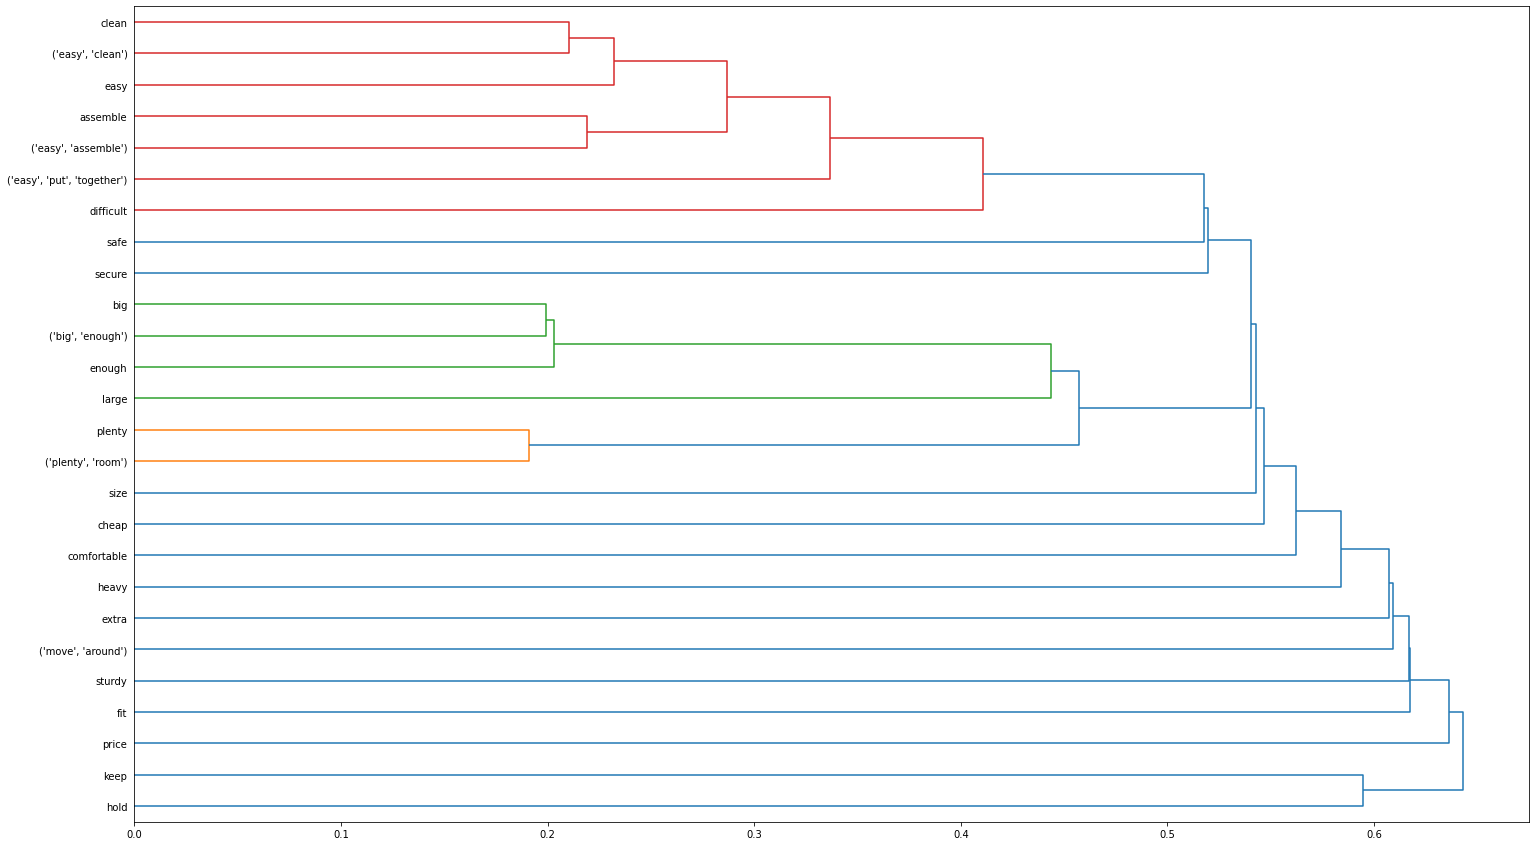

In [118]:
fig = plt.figure(figsize=(25, 15))
dn = dendrogram(Z, orientation='right', labels=list(vec_features.keys())) #cosine distance = 1 - consine similarity
plt.show()